In [2]:
import sys

sys.path.append("../")

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt

TIMEFRAME = '1h'
# DATA_PATH = f'/mnt/c/Users/vmodg/source/repos/BeanRepos/crypto-pair-trading/data/{TIMEFRAME}'
DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from statsmodels.tsa.stattools import adfuller as adf
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool

In [6]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTCUSDT',
 'ETHUSDT',
 'BCHUSDT',
 'XRPUSDT',
 'EOSUSDT',
 'LTCUSDT',
 'TRXUSDT',
 'ETCUSDT',
 'LINKUSDT',
 'XLMUSDT',
 'ADAUSDT',
 'XMRUSDT',
 'DASHUSDT',
 'ZECUSDT',
 'XTZUSDT',
 'BNBUSDT',
 'ATOMUSDT',
 'ONTUSDT',
 'IOTAUSDT',
 'BATUSDT',
 'VETUSDT',
 'NEOUSDT',
 'QTUMUSDT',
 'IOSTUSDT',
 'THETAUSDT',
 'ALGOUSDT',
 'ZILUSDT',
 'KNCUSDT',
 'ZRXUSDT',
 'COMPUSDT',
 'OMGUSDT',
 'DOGEUSDT',
 'SXPUSDT',
 'KAVAUSDT',
 'BANDUSDT',
 'RLCUSDT',
 'WAVESUSDT',
 'MKRUSDT',
 'SNXUSDT',
 'DOTUSDT',
 'DEFIUSDT',
 'YFIUSDT',
 'BALUSDT',
 'CRVUSDT',
 'TRBUSDT',
 'RUNEUSDT',
 'SUSHIUSDT',
 'SRMUSDT',
 'EGLDUSDT',
 'SOLUSDT',
 'ICXUSDT',
 'STORJUSDT',
 'BLZUSDT',
 'UNIUSDT',
 'AVAXUSDT',
 'FTMUSDT',
 'HNTUSDT',
 'ENJUSDT',
 'FLMUSDT',
 'TOMOUSDT',
 'RENUSDT',
 'KSMUSDT',
 'NEARUSDT',
 'AAVEUSDT',
 'FILUSDT',
 'RSRUSDT',
 'LRCUSDT',
 'MATICUSDT',
 'OCEANUSDT',
 'CVCUSDT',
 'BELUSDT',
 'CTKUSDT',
 'AXSUSDT',
 'ALPHAUSDT',
 'ZENUSDT',
 'SKLUSDT',
 'GRTUSDT',
 '1INCHUSDT',
 'CHZUSDT',
 'SANDUSDT',
 'ANKRUSDT',
 'BTSUSDT',
 'LITUSDT',
 'UNFIUSDT',
 'REEFUSDT',
 'RVNUSDT',
 'SFPUSDT',
 'XEMUSDT',
 'BTCSTUSDT',
 'COTIUSDT',
 'CHRUSDT',
 'MANAUSDT',
 'ALICEUSDT',
 'HBARUSDT',
 'ONEUSDT',
 'LINAUSDT',
 'STMXUSDT',
 'DENTUSDT',
 'CELRUSDT',
 'HOTUSDT']
symbols = [s.replace('USDT', '-USDT') for s in symbols]

data = []
start_date = '2019-01-01'
test_end = '2020-12-01'
end_date = '2021-06-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])
        # df = df[df.index > '2022-01-01'].copy()
        df = df[~df.index.duplicated(keep='first')]

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTC-USDT,ETH-USDT,BCH-USDT,XRP-USDT,EOS-USDT,LTC-USDT,TRX-USDT,ETC-USDT,LINK-USDT,XLM-USDT,...,CHR-USDT,MANA-USDT,ALICE-USDT,HBAR-USDT,ONE-USDT,LINA-USDT,STMX-USDT,DENT-USDT,CELR-USDT,HOT-USDT
open_time,,,,,,,,,,,,,,,,,,,,,
2019-10-31 17:00:00,9.132687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 18:00:00,9.131267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 19:00:00,9.129168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 20:00:00,9.125883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 21:00:00,9.120086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def calculate_spread(df, pairs, hedge_ratio):
    spread = None
    for i, symbol in enumerate(pairs):
        if spread is None:
            spread = df[symbol] * hedge_ratio[i]
        else:
            spread += df[symbol] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread

In [8]:
pairs = ['ADA-USDT', 'XMR-USDT']
hedge_ratio = [2.110613783051293, -5.612196646086737]

spread = calculate_spread(df, pairs, hedge_ratio)

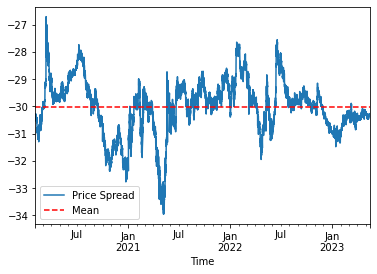

In [9]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [10]:
log_returns = np.log(spread / spread.shift()) * 100
log_returns.dropna(inplace=True)
log_returns.tail()

open_time
2023-05-17 03:00:00   -0.021513
2023-05-17 04:00:00   -0.001871
2023-05-17 05:00:00    0.032619
2023-05-17 06:00:00    0.030025
2023-05-17 07:00:00   -0.000439
Freq: H, Name: ADA-USDT, dtype: float64

In [11]:
def calculate_volatility(returns, rolling_window=7):
    return returns.rolling(rolling_window).std()

baseline_volatility = calculate_volatility(log_returns)


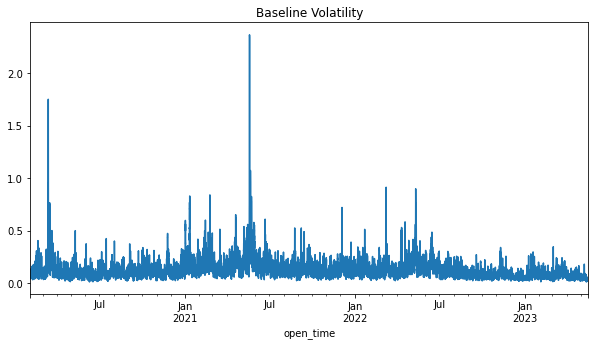

In [12]:
baseline_volatility.plot(figsize=(10,5))
plt.title('Baseline Volatility')
plt.show()


In [13]:
def check_stationarity(returns):
    # Perform the ADF test
    result = adf(returns)

    # Extract the p-value from the test results
    p_value = result[1]

    # Define a significance level (e.g., 0.05)
    significance_level = 0.05

    # Compare the p-value with the significance level
    if p_value < significance_level:
        print("The returns series is likely stationary.")
    else:
        print("The returns series is likely non-stationary.")

# Call the function with your returns series data
check_stationarity(log_returns)

The returns series is likely stationary.


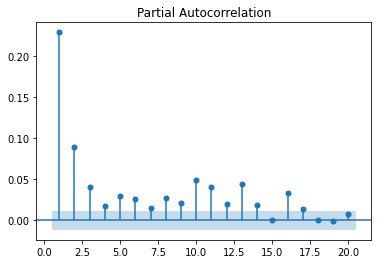

In [14]:
fig = plot_pacf(log_returns**2, lags = 20, zero = False)

## Train-Validation-Test Splits

In [15]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(log_returns) - (val_size + test_size)
split_time_2 = len(log_returns) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = log_returns.index[:split_time_1]
val_idx = log_returns.index[split_time_1:split_time_2]
test_idx = log_returns.index[split_time_2:]

In [16]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = log_returns[train_idx].dropna()
lr_val = log_returns[val_idx].dropna()
lr_test = log_returns[test_idx].dropna()

In [17]:
model = arch_model(lr_train, vol='Garch', p=1, q=1)
model_fit = model.fit()
forecasts = model_fit.forecast(start=0)
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5170683823.081295
Iteration:      2,   Func. Count:     18,   Neg. LLF: 83281.55648418085
Iteration:      3,   Func. Count:     27,   Neg. LLF: 7165903.036279427
Iteration:      4,   Func. Count:     39,   Neg. LLF: 35963.33675703758
Iteration:      5,   Func. Count:     46,   Neg. LLF: 32165303263.300976
Iteration:      6,   Func. Count:     57,   Neg. LLF: -16512.78186100807
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16512.781840804717
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               ADA-USDT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                16512.8
Distribution:                  Normal   AIC:                          -33017.6
Method:            Maximum Likelihood   BIC:                          -32984.5
                                        No. Observations:                28380
Date:                Fri, Jun 30 2023   Df Residuals:                    28379
Time:                        08:15:01   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.4024e-04  6.917e-04      1.359      0.174 [-4.155e-04,2.296e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.2155e-04  5.419e-04      0.962      0.336 [-5.406e-04,1.584e-03]
alpha[1]       0.0971  4.312e-02      2.252  2.432e-02    [1.260e-02,  0.182]
beta[1]        0.8837  6.506e-02     13.582  5.104e-42      [  0.756,  1.011]
=============================================================================

Covariance estimator: robust
"""

In [18]:

def fit_garch_model(params, returns):
    p = params['p']
    q = params['q']
    
    # Create the GARCH(p, q) model
    model = arch_model(returns, vol='Garch', p=p, q=q)

    # Fit the model
    result = model.fit(disp='off')

    # Get the AIC score
    aic = result.aic

    return (params, result, aic, p, q)

def find_best_garch_model(returns):
    # Define the range of parameters to search over
    p_values = list(range(1, 20))  # GARCH(p, q) p-values
    q_values = list(range(1, 20))  # GARCH(p, q) q-values

    # Create a parameter grid for the GARCH(p, q) model
    param_grid = ParameterGrid({'p': p_values, 'q': q_values})

    # Initialize variables to track the best model and its corresponding AIC
    best_model = None
    best_aic = float("inf")
    best_p = None
    best_q = None

    # Create a pool of workers for multiprocessing
    pool = Pool()

    # Fit GARCH models using multiprocessing
    results = pool.starmap(fit_garch_model, [(params, returns) for params in param_grid])

    # Close the pool of workers
    pool.close()
    pool.join()

    # Iterate over the results and find the best model
    for params, result, aic, p, q in results:
        if aic < best_aic:
            best_aic = aic
            best_model = result
            best_p = p
            best_q = q

    # Print the best model's summary and return the model object
    print('Params', best_p, best_q)
    print(best_model.summary())
    return best_model

# Call the function with your returns series data
best_garch_model = find_best_garch_model(log_returns)
# best_garch_model

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive direction

Params 10 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               ADA-USDT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                17328.0
Distribution:                  Normal   AIC:                          -34602.0
Method:            Maximum Likelihood   BIC:                          -34378.8
                                        No. Observations:                28775
Date:                Fri, Jun 30 2023   Df Residuals:                    28774
Time:                        08:15:22   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.0185e-04  6.858e-04      0.73

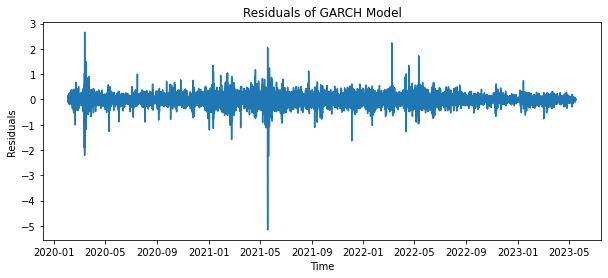

In [19]:
# Obtain model estimated residuals and volatility
gm_resid = best_garch_model.resid
gm_std = best_garch_model.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the residuals over time
plt.figure(figsize=(10, 4))
plt.plot(gm_resid)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals of GARCH Model')
plt.show()

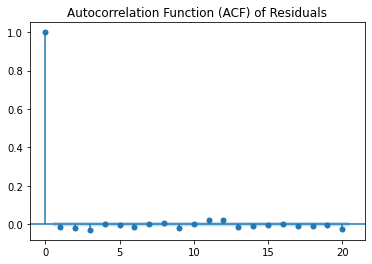

In [20]:
# Plot the autocorrelation function (ACF) of residuals
plot_acf(gm_resid, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

Ljung-Box test p-values: [2.58153986e-02 9.75343163e-05 1.19987434e-09 4.83906561e-09
 1.66503217e-08 4.83334529e-09 1.32381630e-08 2.98944849e-08
 1.14226681e-09 2.86178617e-09 1.12198449e-11 6.58493787e-14
 2.52554333e-14 1.50826940e-14 2.68062848e-14 7.05943854e-14
 5.41910363e-14 3.89769710e-14 5.49433250e-14 1.13706936e-16]
Jarque-Bera test p-value: 0.0


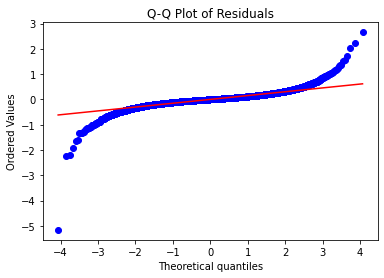

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera, probplot

# Obtain the residuals
residuals = best_garch_model.resid

# Ljung-Box test for residual autocorrelation
lb_stat, lb_p_value = acorr_ljungbox(residuals, lags=20)
print(f"Ljung-Box test p-values: {lb_p_value}")

# Jarque-Bera test for normality of residuals
jb_stat, jb_p_value = jarque_bera(residuals)
print(f"Jarque-Bera test p-value: {jb_p_value}")

# Q-Q plot of residuals
plt.figure(figsize=(6, 4))
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

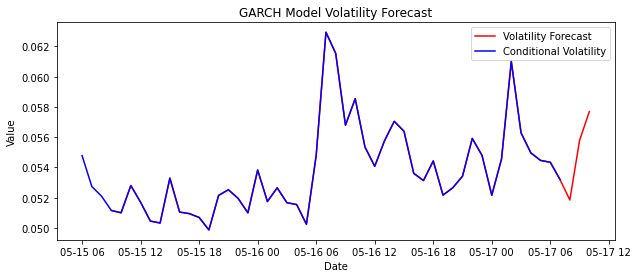

In [53]:
# Forecast volatility
forecast_horizon = 3  # Define the number of periods for volatility forecast
forecast = best_garch_model.forecast(horizon=forecast_horizon)
# np.sqrt(forecast.variance.values[-1, :])
# # Extract the forecasted volatility
volatility_forecast = np.sqrt(forecast.variance.values[-1, :])
# volatility_forecast

last_date = best_garch_model.conditional_volatility.index[-1]
forecast_index = pd.date_range(
    start=last_date + pd.DateOffset(hours=1), periods=forecast_horizon, freq="H"
)
forecast_index

# Append the forecasted volatility to the existing conditional_volatility series
combined_volatility = np.concatenate(
    [best_garch_model.conditional_volatility, volatility_forecast]
)
combined_index = pd.DatetimeIndex(
    np.concatenate([best_garch_model.conditional_volatility.index, forecast_index])
)

# Create a new DataFrame with the combined volatility and index
combined_df = pd.DataFrame(
    data=combined_volatility, index=combined_index, columns=["Volatility"]
)
combined_df = combined_df.tail(50)

# Plot the volatility forecast as an indicator
plt.figure(figsize=(10, 4))
plt.plot(combined_df.index, combined_df["Volatility"], color='red', label="Volatility Forecast")
plt.plot(
    best_garch_model.conditional_volatility.tail(50).index,
    best_garch_model.conditional_volatility.tail(50),
    color="blue",
    label="Conditional Volatility",
)
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("GARCH Model Volatility Forecast")
plt.legend()
plt.show()
